In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px

from fbprophet import Prophet
from sklearn.metrics import r2_score

plt.style.use("ggplot")

df0 = pd.read_csv("CONVENIENT_global_confirmed_cases.csv")
df1 = pd.read_csv("CONVENIENT_global_deaths.csv")

In [8]:
df0,df1

(     Country/Region  Afghanistan  Albania  ...  Yemen  Zambia  Zimbabwe
 0    Province/State          NaN      NaN  ...    NaN     NaN       NaN
 1           1/23/20          0.0      0.0  ...    0.0     0.0       0.0
 2           1/24/20          0.0      0.0  ...    0.0     0.0       0.0
 3           1/25/20          0.0      0.0  ...    0.0     0.0       0.0
 4           1/26/20          0.0      0.0  ...    0.0     0.0       0.0
 ..              ...          ...      ...  ...    ...     ...       ...
 733         1/24/22        247.0      0.0  ...    0.0   294.0     287.0
 734         1/25/22        356.0    789.0  ...    0.0   645.0     235.0
 735         1/26/22        440.0   2156.0  ...  236.0   697.0     167.0
 736         1/27/22        312.0   1562.0  ...   67.0   736.0     153.0
 737         1/28/22         53.0   1549.0  ...   54.0   351.0     237.0
 
 [738 rows x 281 columns],
      Country/Region  Afghanistan  Albania  ...  Yemen  Zambia  Zimbabwe
 0    Province/State  

In [10]:
world = pd.DataFrame({"Country":[],"Cases":[]})
world["Country"] = df0.iloc[:,1:].columns
cases = []
for i in world["Country"]:
    cases.append(pd.to_numeric(df0[i][1:]).sum())
world["Cases"]=cases

country_list=list(world["Country"].values)
idx = 0
for i in country_list:
    sayac = 0
    for j in i:
        if j==".":
            i = i[:sayac]
            country_list[idx]=i
        elif j=="(":
            i = i[:sayac-1]
            country_list[idx]=i
        else:
            sayac += 1
    idx += 1
world["Country"]=country_list
world = world.groupby("Country")["Cases"].sum().reset_index()
world.head()
continent=pd.read_csv("continents2.csv")
continent["name"]=continent["name"].str.upper()

In [11]:
world["Cases Range"]=pd.cut(world["Cases"],[-150000,50000,200000,800000,1500000,15000000],labels=["U50K","50Kto200K","200Kto800K","800Kto1.5M","1.5M+"])
alpha =[]
for i in world["Country"].str.upper().values:
    if i == "BRUNEI":
        i="BRUNEI DARUSSALAM"
    elif  i=="US":
        i="UNITED STATES" 
    if len(continent[continent["name"]==i]["alpha-3"].values)==0:
        alpha.append(np.nan)
    else:
        alpha.append(continent[continent["name"]==i]["alpha-3"].values[0])
world["Alpha3"]=alpha

fig = px.choropleth(world.dropna(),
                   locations="Alpha3",
                   color="Cases Range",
                    projection="mercator",
                    color_discrete_sequence=["white","khaki","yellow","orange","red"])
fig.update_geos(fitbounds="locations", visible=False)
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

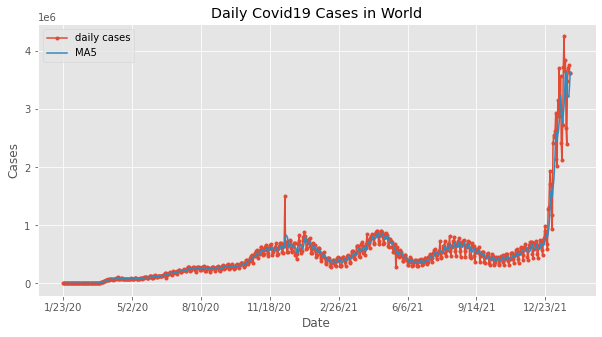

In [13]:
count = []
for i in range(1,len(df0)):
    count.append(sum(pd.to_numeric(df0.iloc[i,1:].values)))

df = pd.DataFrame()
df["Date"] = df0["Country/Region"][1:]
df["Cases"] = count
df=df.set_index("Date")

count = []
for i in range(1,len(df1)):
    count.append(sum(pd.to_numeric(df1.iloc[i,1:].values)))

df["Deaths"] = count

df.Cases.plot(title="Daily Covid19 Cases in World",marker=".",figsize=(10,5),label="daily cases")
df.Cases.rolling(window=5).mean().plot(figsize=(10,5),label="MA5")
plt.ylabel("Cases")
plt.legend()
plt.show()

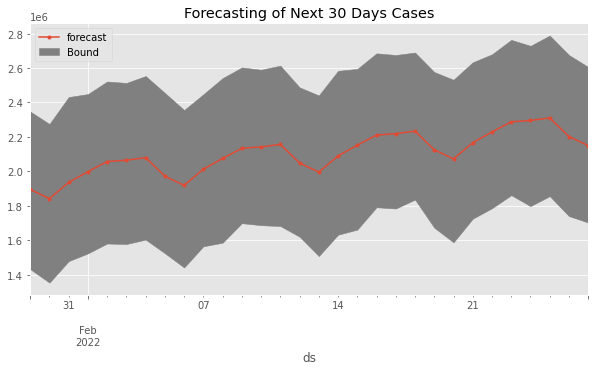

In [14]:
class Fbprophet(object):
    def fit(self,data):
        
        self.data  = data
        self.model = Prophet(weekly_seasonality=True,daily_seasonality=False,yearly_seasonality=False)
        self.model.fit(self.data)
    
    def forecast(self,periods,freq):
        
        self.future = self.model.make_future_dataframe(periods=periods,freq=freq)
        self.df_forecast = self.model.predict(self.future)
        
    def plot(self,xlabel="Years",ylabel="Values"):
        
        self.model.plot(self.df_forecast,xlabel=xlabel,ylabel=ylabel,figsize=(9,4))
        self.model.plot_components(self.df_forecast,figsize=(9,6))
        
    def R2(self):
        return r2_score(self.data.y, self.df_forecast.yhat[:len(df)])
        
df_fb  = pd.DataFrame({"ds":[],"y":[]})
df_fb["ds"] = pd.to_datetime(df.index)
df_fb["y"]  = df.iloc[:,0].values

model = Fbprophet()
model.fit(df_fb)
model.forecast(30,"D")
model.R2()

forecast = model.df_forecast[["ds","yhat_lower","yhat_upper","yhat"]].tail(30).reset_index().set_index("ds").drop("index",axis=1)
forecast["yhat"].plot(marker=".",figsize=(10,5))
plt.fill_between(x=forecast.index, y1=forecast["yhat_lower"], y2=forecast["yhat_upper"],color="gray")
plt.legend(["forecast","Bound"],loc="upper left")
plt.title("Forecasting of Next 30 Days Cases")
plt.show()